# U-net для сегментации и выделения фасада здания
В данном ноутбуке будет построена свёрточная нейронная сеть архитектуры U-net для выделения фасада здания.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
# Обработка данных
from colour import Color
from tqdm import tqdm
from PIL import Image

# Отрисовка графиков
import matplotlib.pyplot as plt


# Работа с изображениями
import cv2
import skimage
import skimage.io
import skimage.transform
from skimage.color import gray2rgb
import imageio
from os.path import isfile, join

import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install colour

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from PIL import ImageOps

In [3]:
class ImageDataset(Dataset):
    
    def __init__(
        self,
        root,
        transform=None,
        ):
        
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])
        
        def load_images(path):

            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir
        
        self.data_path = load_images(self.root + '/TrainA')
        self.labels_path = load_images(self.root + '/TrainB')
        
    def __getitem__(self, index):
        
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()
            
        return (img, target)
    
    def __len__(self):
        return len(self.data_path)
    
def im_show(img_list):
    
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception('len(img_list) must be smaller than 10')
        
    for (idx, img) in enumerate(img_list):
        img = np.array(to_PIL(img))
        plt.figure(figsize=(4,4))
        fig = plt.imshow(img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()
        

In [4]:
import PIL

In [32]:
train_dataset = ImageDataset(root='D:/CV/',
                            transform=transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()
                                ])
                            )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

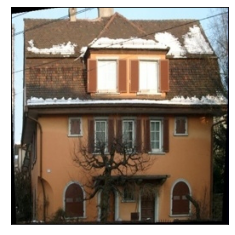

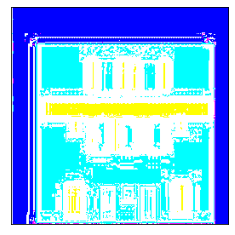

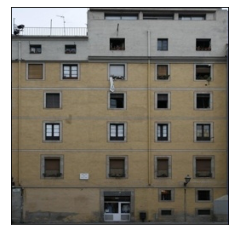

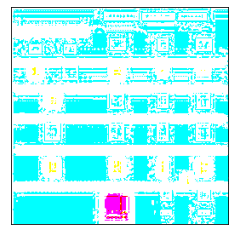

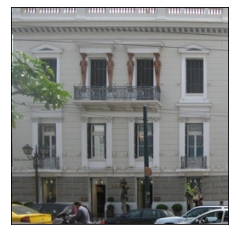

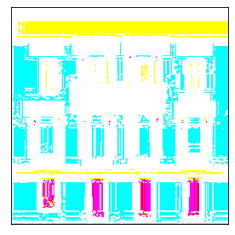

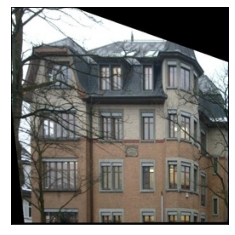

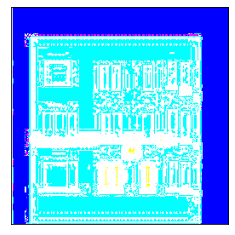

In [34]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0,100)]
    img_list.append(img)
    img_list.append(label)
    
im_show(img_list)

In [13]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,
                             padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down_1 = nn.Sequential(            # Первый свёрточный слой
            ConvBlock(3, 32),
            ConvBlock(32, 64, stride=2, padding=1))
        
        self.down_2 = nn.Sequential(            # Второй свёрточный слой
            ConvBlock(64, 128),
            ConvBlock(128, 256))
        
        self.down_3 = nn.Sequential(
            ConvBlock(256, 512),
            ConvBlock(512, 1024))
        
        self.down_4 = nn.Sequential(
            ConvBlock(1024, 2048),
            ConvBlock(2048, 4096))
        
        self.middle = ConvBlock(4096, 4096, kernel_size=1, padding=0)    # Сворачиваем тензор в вектор
        
        self.up_4 = nn.Sequential(
            ConvBlock(4096*2, 4096),
            ConvBlock(4096, 1024))
        
        self.up_3 = nn.Sequential(
            ConvBlock(2048, 1024),
            ConvBlock(1024, 256))
        
        self.up_2 = nn.Sequential(            # Развёртка второго свёрточного слоя
            ConvBlock(512, 256),              # вдвое больше каналов за счёт совмещения изображений
            ConvBlock(256, 64))
        
        self.up_1 = nn.Sequential(            # Развёртка первого свёрточного слоя
            ConvBlock(128, 128),                # вдвое больше каналов за счёт совмещения изображений
            ConvBlock(128,64))
        
        self.output = nn.Sequential(
            ConvBlock(64, 32),
            ConvBlock(32, 3, kernel_size=1, padding=0))

    def forward(self,x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)
        
        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)
    
        down3 = self.down_3(out)
        out = F.max_pool2d(down3, kernel_size=2, stride=2)
        
        down4 = self.down_4(out)
        out = F.max_pool2d(down4, kernel_size=2, stride=2)
        
        out = self.middle(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down4, out], 1)
        out = self.up_4(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)  # интерполяцией увеличиваем в два раза размер фильтра
        out = torch.cat([down3, out], 1)
        out = self.up_3(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)  # интерполяцией увеличиваем в два раза размер фильтра
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        return self.output(out)
        

In [5]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,
                             padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        self.down_1 = nn.Sequential(            # Первый свёрточный слой
            ConvBlock(3, 16),
            ConvBlock(16, 32, stride=2, padding=1))
        
        self.down_2 = nn.Sequential(            # Второй свёрточный слой
            ConvBlock(32, 64),
            ConvBlock(64, 128))
        
        self.down_3 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 512))
        
        self.down_4 = nn.Sequential(
            ConvBlock(512, 1024),
            ConvBlock(1024, 2048))
        
        self.middle = ConvBlock(2048, 2048, kernel_size=1, padding=0)    # Сворачиваем тензор в вектор
        
        self.up_4 = nn.Sequential(
            ConvBlock(4096, 2048),
            ConvBlock(2048, 512))
        
        self.up_3 = nn.Sequential(
            ConvBlock(1024, 512),
            ConvBlock(512, 128))
        
        self.up_2 = nn.Sequential(            # Развёртка второго свёрточного слоя
            ConvBlock(256, 128),              # вдвое больше каналов за счёт совмещения изображений
            ConvBlock(128, 32))
        
        self.up_1 = nn.Sequential(            # Развёртка первого свёрточного слоя
            ConvBlock(64, 64),                # вдвое больше каналов за счёт совмещения изображений
            ConvBlock(64,32))
        
        self.output = nn.Sequential(
            ConvBlock(32, 16),
            ConvBlock(16, 3, kernel_size=1, padding=0))

    def forward(self,x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)
        
        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)
    
        down3 = self.down_3(out)
        out = F.max_pool2d(down3, kernel_size=2, stride=2)
        
        down4 = self.down_4(out)
        out = F.max_pool2d(down4, kernel_size=2, stride=2)
        
        out = self.middle(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down4, out], 1)
        out = self.up_4(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)  # интерполяцией увеличиваем в два раза размер фильтра
        out = torch.cat([down3, out], 1)
        out = self.up_3(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)  # интерполяцией увеличиваем в два раза размер фильтра
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)
        
        out = nn.functional.interpolate(out, scale_factor=2)
        return self.output(out)
        

In [6]:
def train(train_loader, model, criterion, epoch, num_epochs):
    model.train()
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        
        images = images
        labels = labels

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))
        
        loss = criterion(outputs, labels)
        
        accuracy = ((outputs > 0.5) == labels).float().mean()
        
        pbar.set_description(
                f'Loss : {round(loss.item(), 4)}'
                f'Accuracy: {round(accuracy.item() * 100, 4)}'
        )
        
        loss.backward()
        optimizer.step()

In [ ]:
model = Unet()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(),
                                weight_decay=1e-5,
                                lr=1e-3,
                                momentum=0.9)

num_epochs = 10
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs)
    if epoch % 2 == 0:
        torch.save(model, f'segment_model_epoch_{epoch}.pth.tar')

Loss : 0.3702Accuracy: 83.3031: 100%|██████████| 100/100 [23:55<00:00, 14.35s/it]


Напишем функции для выделения фасада здания:

In [ ]:
torch.save(model, 'segment_model_epoch_8.pth.tar')

In [59]:
class ImageDataset(Dataset):
    
    def __init__(
        self,
        root,
        transform=None,
        ):
        
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])
        
        def load_images(path):

            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir
        
        self.data_path = load_images(self.root)
        self.labels_path = load_images(self.root)
        
    def __getitem__(self, index):
        
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()
            
        return (img, target)
    
    def __len__(self):
        return len(self.data_path)

In [84]:
def facade_segment(img_path, model, idx):
    image = ImageDataset(root=img_path,
                            transform=transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()
                                ])
                            )
    img, label = image[idx]
    prediction = model(img.unsqueeze(0)).squeeze(0).cpu()
    to_PIL = transforms.ToPILImage()
    image = np.array(to_PIL(img))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image1 = np.array(to_PIL(prediction))
    img = image*np.array((image1[:,:, 1] > 10) & (image1[:,:, 1] < 300))
    print('--------- Вывожу сегмент фасада ------------')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

In [21]:
model = torch.load('segment_model_epoch_8.pth.tar')

--------- Вывожу сегмент фасада ------------


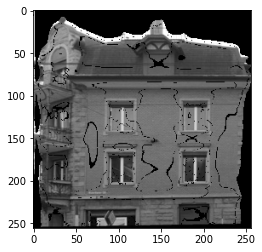

In [85]:
facade_segment(img_path='D:/CV/test', model=model, idx=0)